In [1]:
library(SingleCellExperiment)
library(Seurat)
library(mclust)
library(dplyr)

Loading required package: SummarizedExperiment
Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengths, Map, mapply, match,
    mget, order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rowMeans, rownames, rowSums, sapply, setdiff, sort,
    table, tapply, union, unique, unsp

In [2]:
pdata <- readRDS("source/prdata.sagar")

In [3]:
seuset <- CreateSeuratObject(
    raw.data = pdata,
    min.cells = 3, 
    min.genes = 10
)

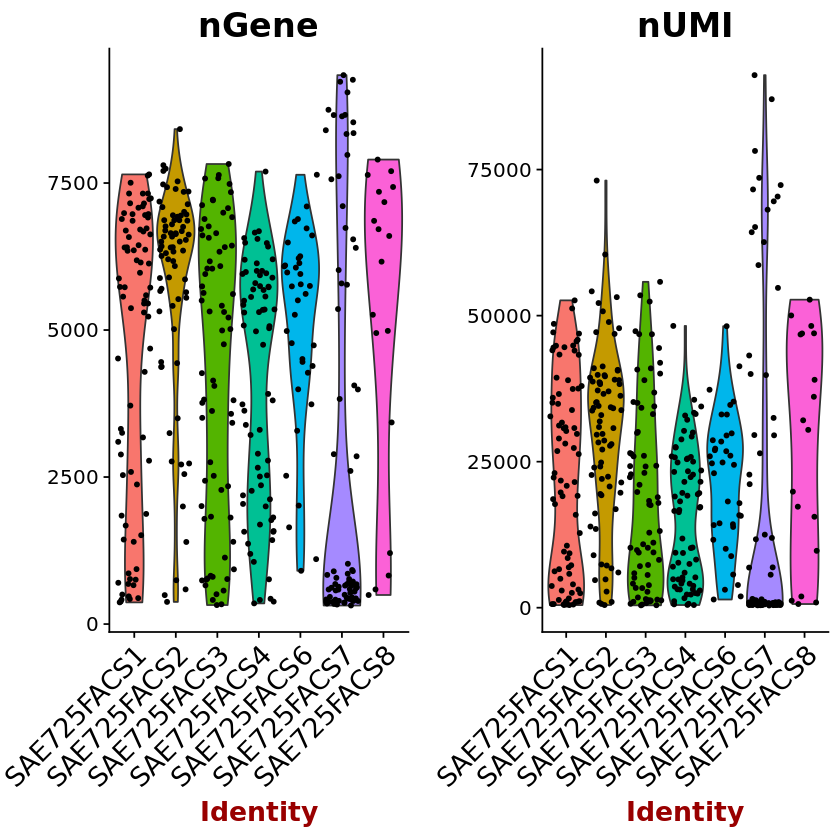

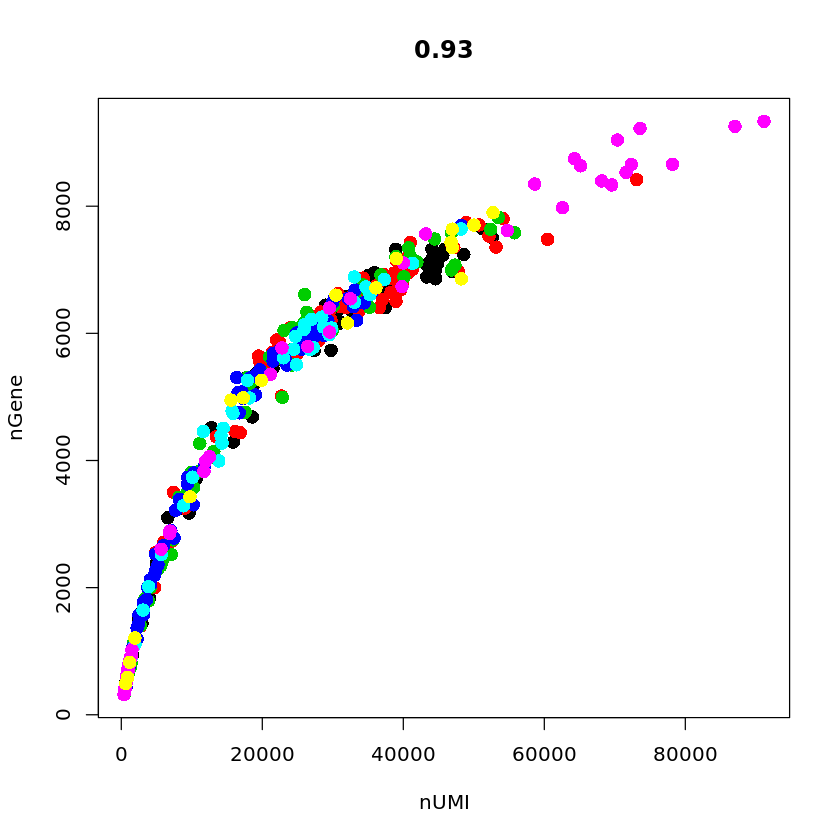

In [5]:
VlnPlot(
    object = seuset, 
    features.plot = c("nGene", "nUMI"),
    x.lab.rot = 90,
    nCol = 2
)

# Most counts are 0 except in Batch 6 where it's more spread.
# Batch 7 has some bias for low number of genes
GenePlot(
    object = seuset, 
    gene1 = "nUMI", 
    gene2 = "nGene"
)

In [8]:
dim(seuset@data)

[1] 16195   430

In [9]:
seuset_f <- FilterCells(
    object = seuset, 
    subset.names = c("nUMI"), 
    high.thresholds = c(2e7),
    low.thresholds = c(3000)
)

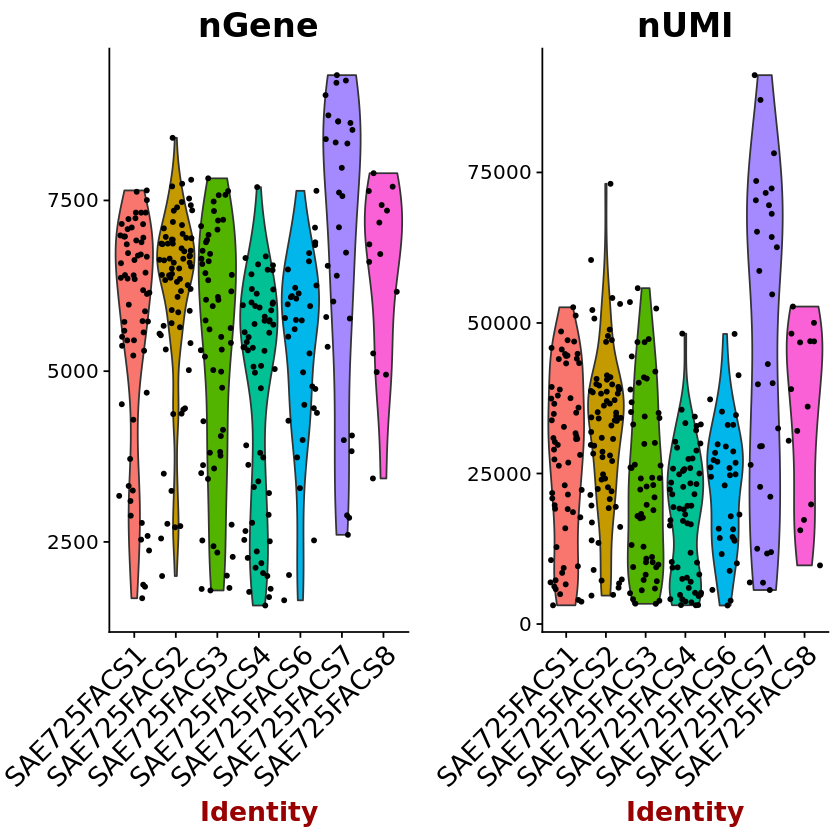

[1] 16195   326

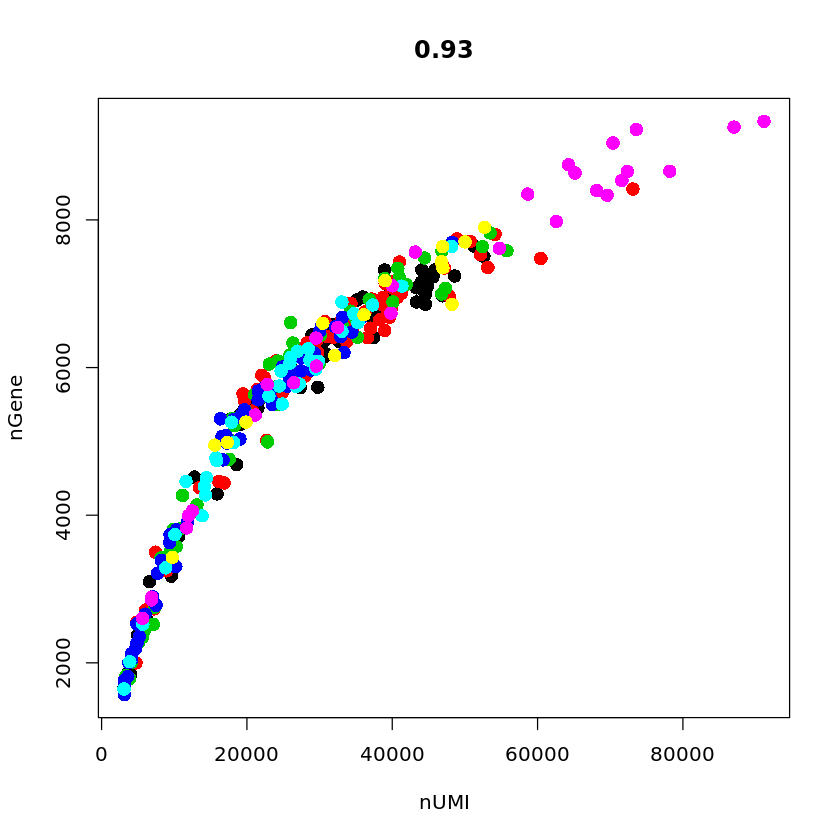

In [11]:
VlnPlot(
    object = seuset_f, 
    features.plot = c("nGene", "nUMI"),
    x.lab.rot = 90,
    nCol = 2
)

GenePlot(
    object = seuset_f, 
    gene1 = "nUMI", 
    gene2 = "nGene"
)

dim(seuset_f@data)

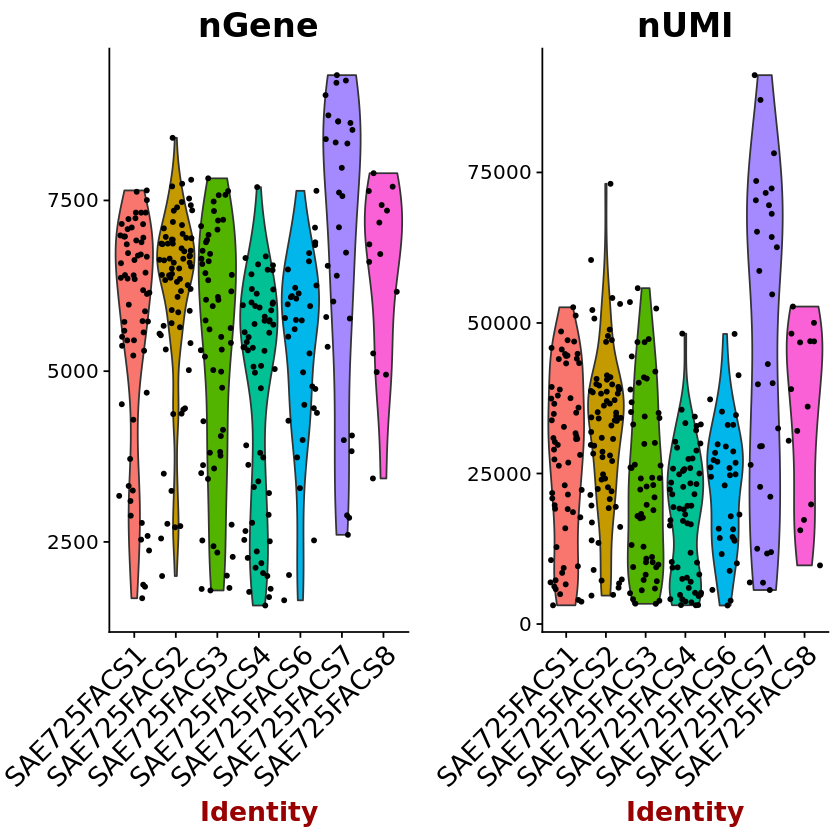

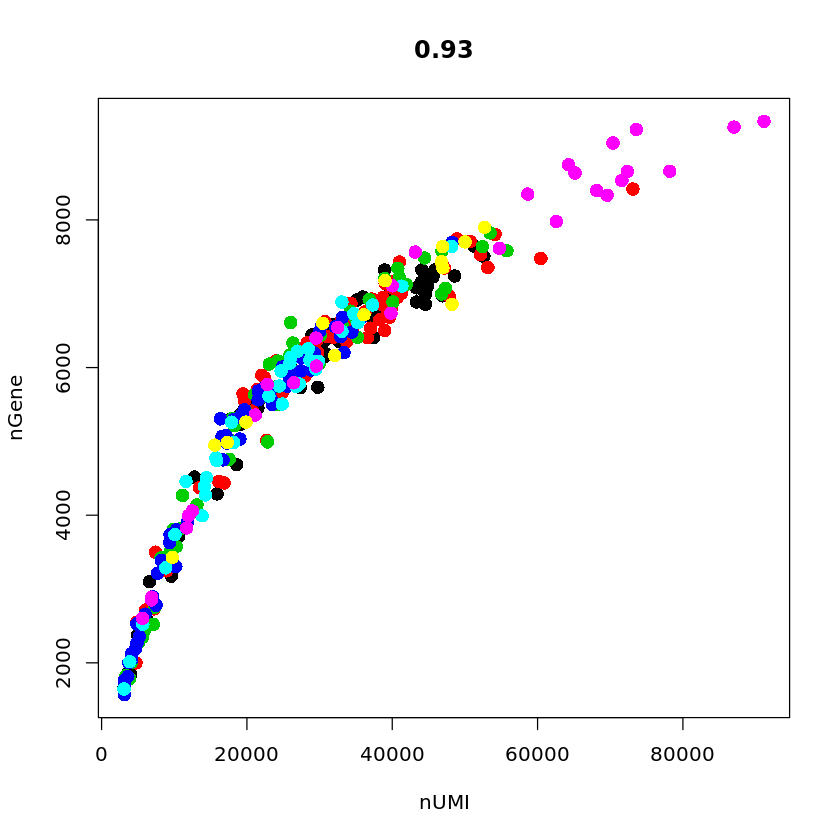

In [12]:
seuset_n <- NormalizeData(
    object = seuset_f, 
    normalization.method = "LogNormalize", 
    scale.factor = 10000
)

VlnPlot(
    object = seuset_n, 
    features.plot = c("nGene", "nUMI"),
    x.lab.rot = 90,
    nCol = 2
)

GenePlot(
    object = seuset_n, 
    gene1 = "nUMI", 
    gene2 = "nGene"
)

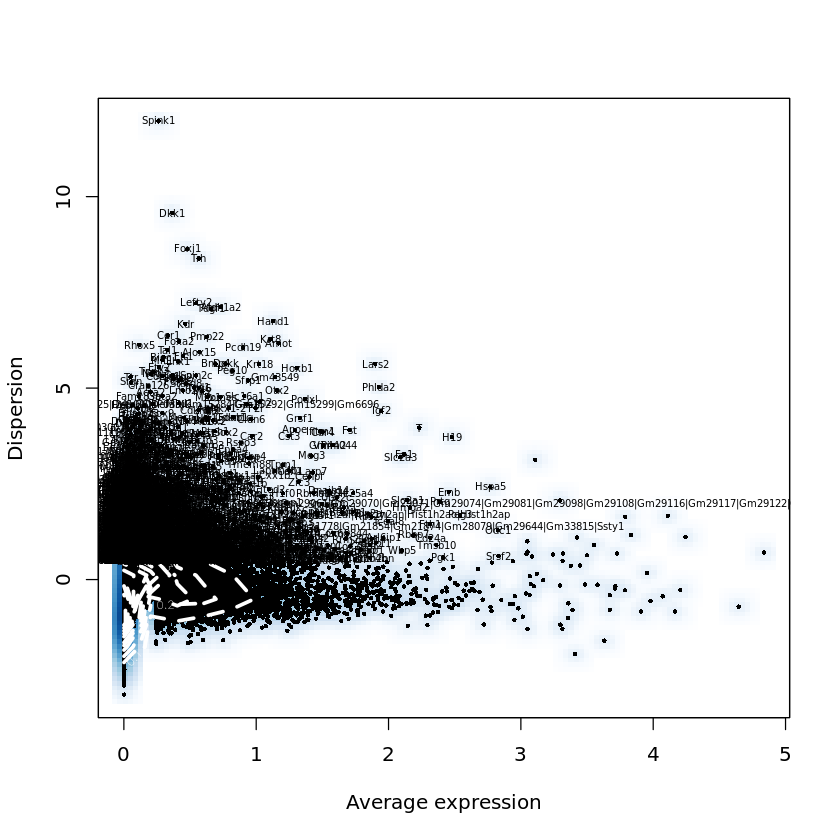

In [13]:
seuset_fvg <- FindVariableGenes(
    object = seuset_n,
    mean.function = ExpMean, 
    dispersion.function = LogVMR, 
    x.low.cutoff = 0.0125, 
    x.high.cutoff = 3, 
    y.cutoff = 0.5
)

In [14]:
length(x = seuset_fvg@var.genes)

seuset_sd <- ScaleData(
    object = seuset_fvg, 
    vars.to.regress = c("nUMI")
)

[1] 3452

[1] "Regressing out nUMI"
  |======================================================================| 100%
Time Elapsed:  36.2591381072998 secs
[1] "Scaling data matrix"
  |======================================================================| 100%


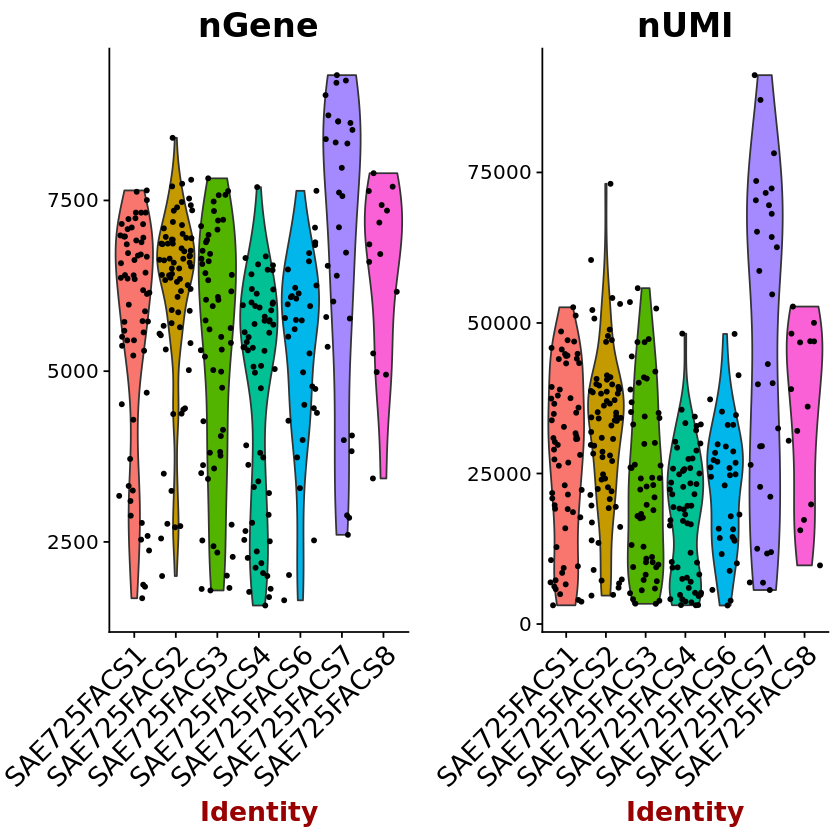

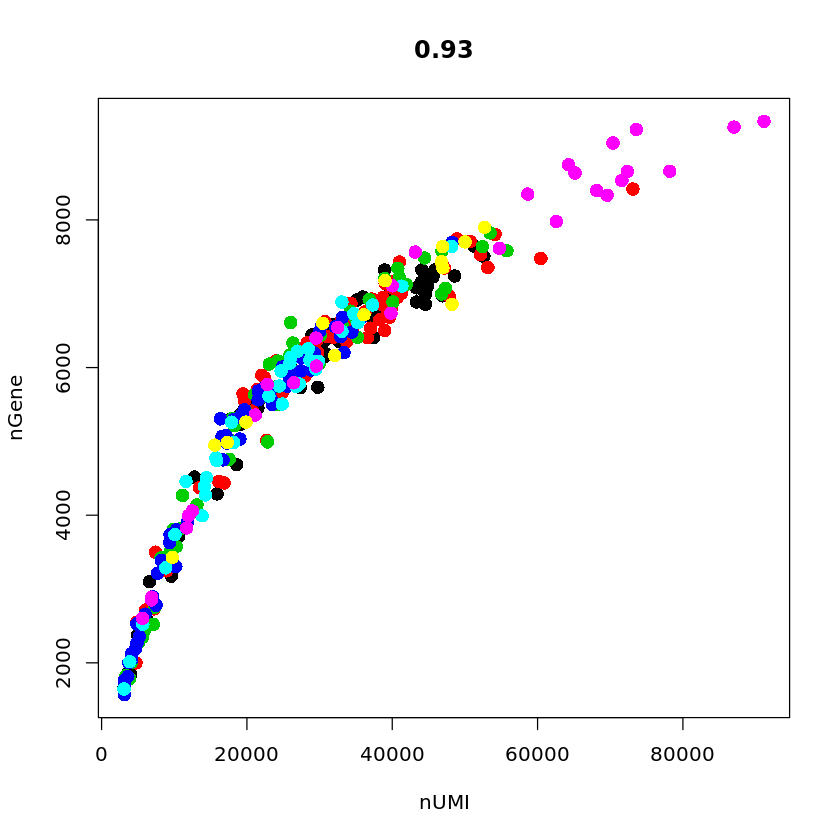

In [15]:
VlnPlot(
    object = seuset_sd, 
    features.plot = c("nGene", "nUMI"),
    x.lab.rot = 90,
    nCol = 2
)

GenePlot(
    object = seuset_sd, 
    gene1 = "nUMI", 
    gene2 = "nGene"
)

In [16]:
seuset_pca <- RunPCA(
    object = seuset_sd,
    pc.genes = seuset_sd@var.genes,
    do.print = TRUE,
    pcs.print = 1:5,
    genes.print = 5
)

[1] "PC1"
[1] "Srsf2" "Srm"   "Rrm2"  "Snhg1" "H19"  
[1] ""
[1] "Dnajb13"       "Fam183b"       "Pifo"          "Cfap126"      
[5] "1110017D15Rik"
[1] ""
[1] ""
[1] "PC2"
[1] "Igf2"  "H19"   "Rbms1" "Peg10" "Ppic" 
[1] ""
[1] "Pim2"   "Sox2"   "Cdh1"   "Pou5f1" "Zic5"  
[1] ""
[1] ""
[1] "PC3"
[1] "Hoxb1" "Meis2" "Tbx6"  "Fst"   "Dll3" 
[1] ""
[1] "Podxl"  "Slc2a3" "Cgnl1"  "Car4"   "Cldn6" 
[1] ""
[1] ""
[1] "PC4"
[1] "Slc2a3" "Meg3"   "Vangl1" "Iqgap1" "B3gnt7"
[1] ""
[1] "Foxc2"  "Rps27l" "Twist1" "Crabp1" "Irx1"  
[1] ""
[1] ""
[1] "PC5"
[1] "Pgk1"    "Akap12"  "Bex4"    "B4galt5" "Nkx1-2" 
[1] ""
[1] "Cer1"   "Spink1" "Eda"    "Hnf1b"  "Lcp1"  
[1] ""
[1] ""


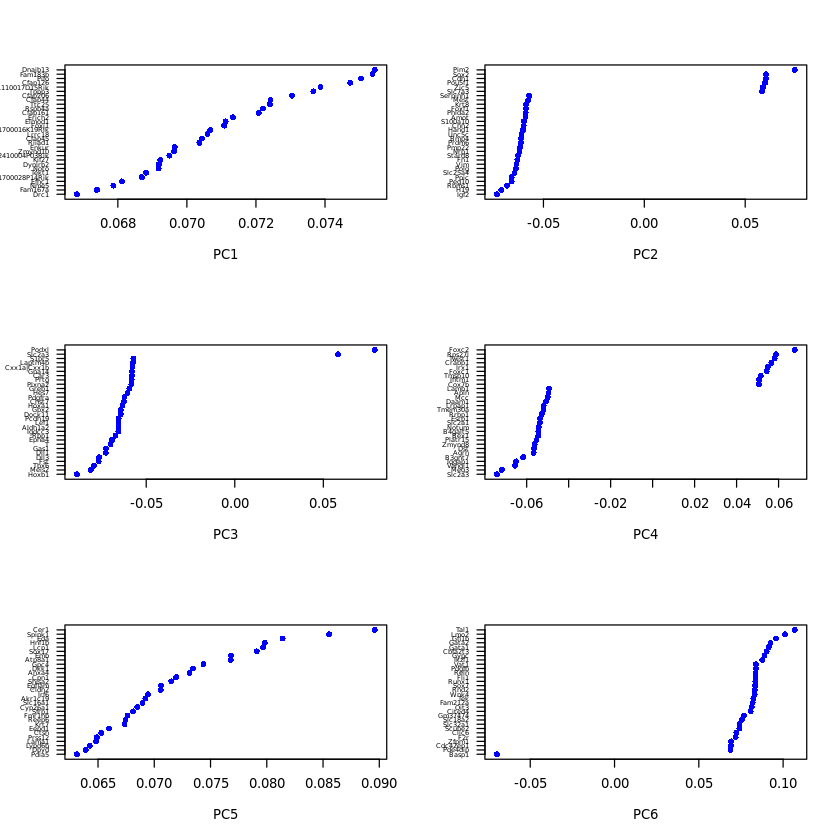

In [18]:
#PrintPCA(object = seuset_pca, pcs.print = 1:5, genes.print = 5, use.full = FALSE)
VizPCA(object = seuset_pca, pcs.use = 1:6)

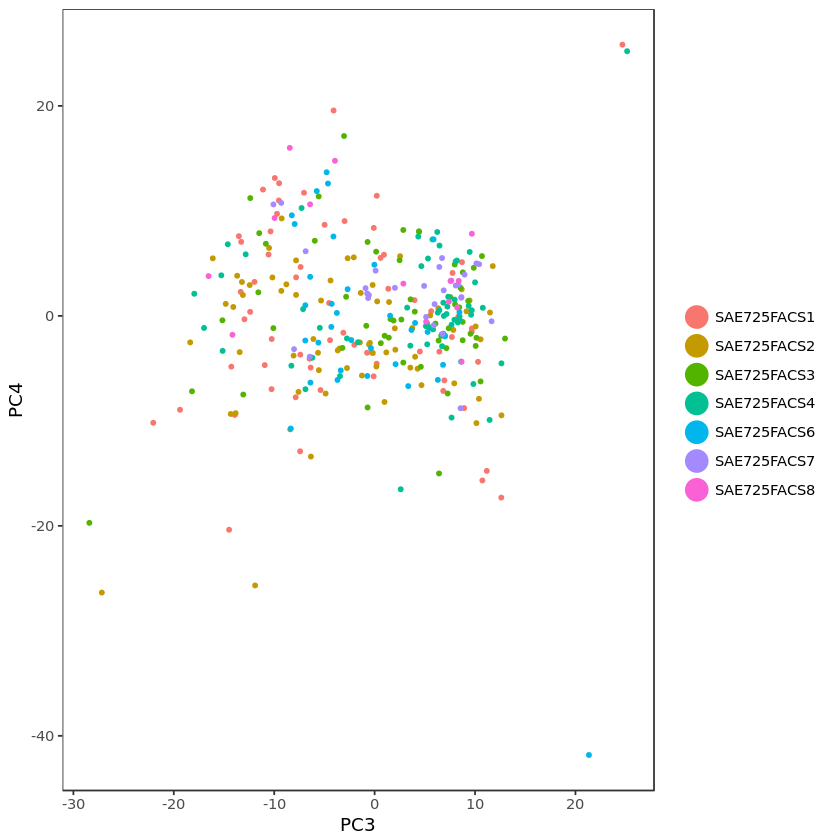

In [21]:
PCAPlot(object = seuset_pca, dim.1 = 3, dim.2 = 4, num.genes = 500)

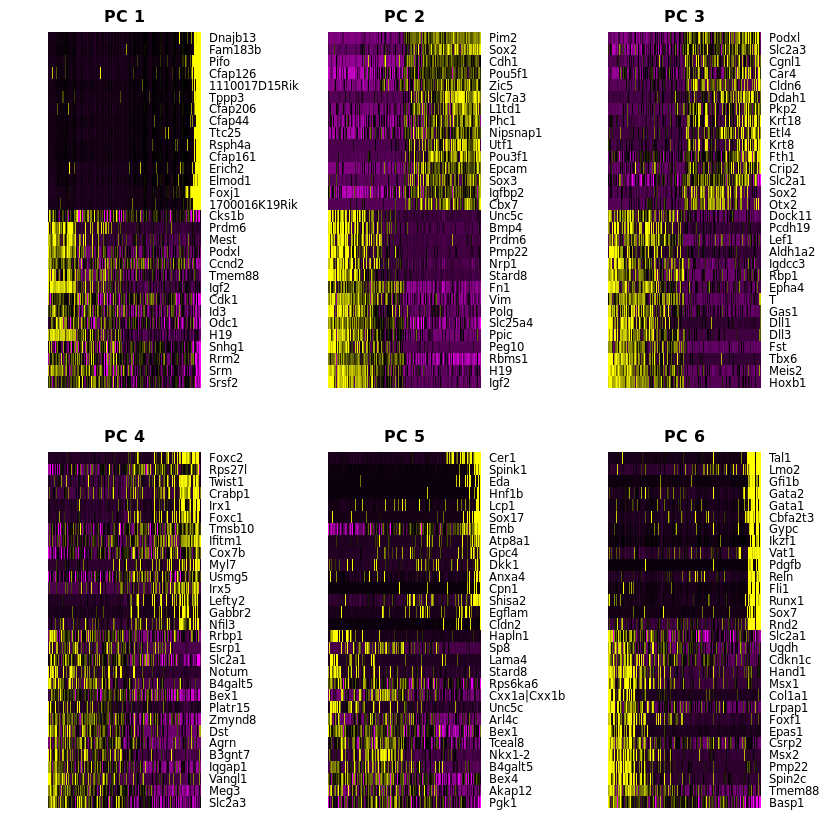

In [22]:
PCHeatmap(
    object = seuset_pca, 
    pc.use = 1:6, 
    cells.use = 200, 
    do.balanced = TRUE, 
    label.columns = FALSE,
    use.full = FALSE
)

In [23]:
seuset_js <- JackStraw(
    object = seuset_pca,
    num.replicate = 100, 
)

  |======================================================================| 100%
Time Elapsed:  1.2910555322965 mins 



Warning message:
“Removed 22221 rows containing missing values (geom_point).”

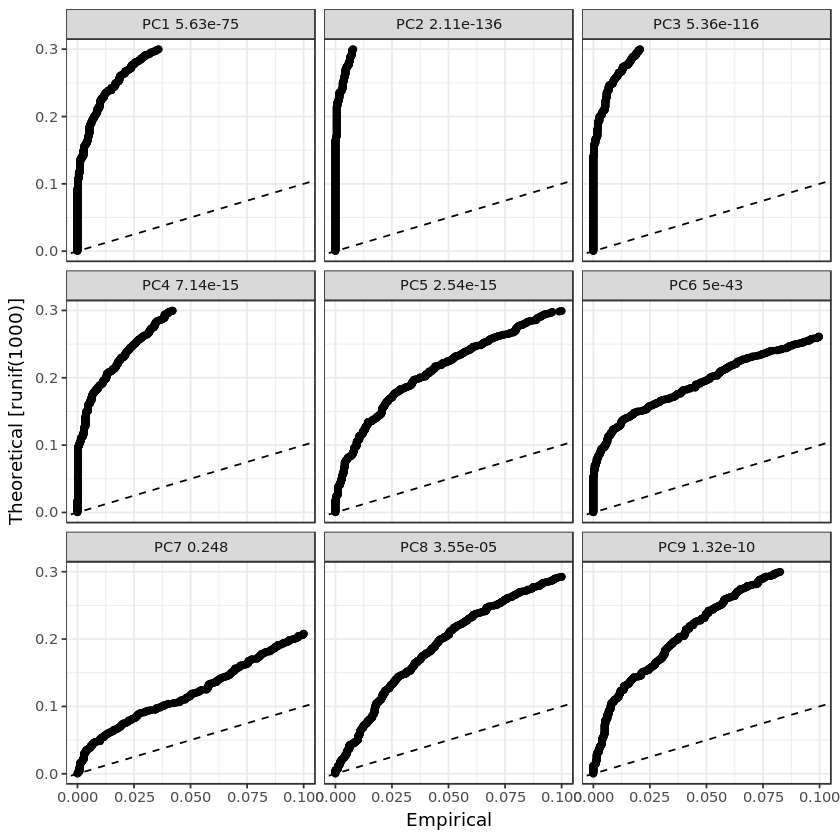

In [24]:
JackStrawPlot(object = seuset_js, PCs = 1:9)

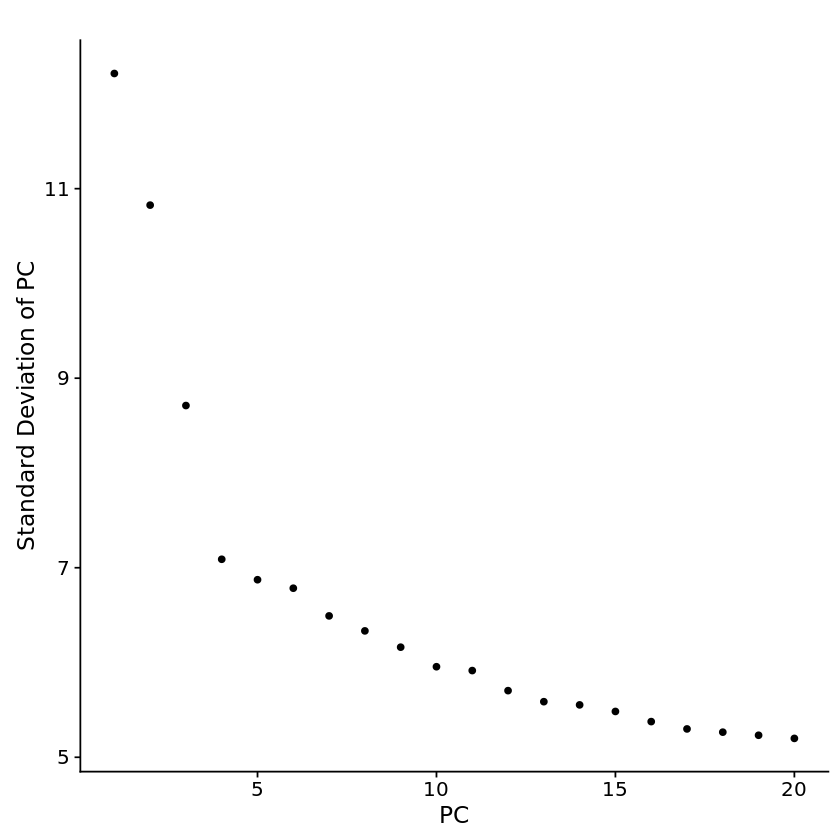

In [25]:
# PCs 1-3 v sig, PCs 4-6 less so
PCElbowPlot(object = seuset_js)
# Elbow shows that 4th PC is the cutoff

In [33]:
limrange=2:10

seu_filts <- list()

for (lim in limrange){
    seu_filts[[lim]] <- FindClusters(
        object = seuset_js, 
        reduction.type = "pca", 
        dims.use = 1:lim, 
        resolution = 1.0, 
        print.output = 0, 
        save.SNN = TRUE
    )
    cat(lim)
}

tab_filts <- list()

for (lim in limrange){
    seu <- seu_filts[[lim]]
    tab_filts[[lim]] <- table(seu@ident)
}


ERROR: Error in FindClusters(object = seuset_js, reduction.type = "pca", dims.use = 1:lim, : object 'seuset_js' not found


In [62]:
tab <- rbind(
    rbind(lapply(tab_filts, function(x) length(names(x)))),
    rbind(tab_filts)
)
          
colnames(tab) <- c(1,limrange)        
rownames(tab) <- c("Number of clusters", "Freq. clusters")


In [64]:
t(tab)

,Number of clusters,Freq. clusters
1,0,NULL
2,5,"81, 72, 66, 59, 48"
3,7,"59, 53, 50, 49, 49, 43, 23"
4,4,"110, 85, 76, 55"
5,5,"98, 83, 72, 58, 15"
6,5,"100, 80, 72, 57, 17"
7,6,"78, 72, 70, 57, 34, 15"
8,5,"97, 83, 70, 57, 19"
9,5,"96, 84, 70, 58, 18"
10,6,"77, 71, 66, 57, 40, 15"


In [83]:
limrange=2:10
generateTSNEs <- function(){
    
    seu_tsnes <- list()

    for (lim in limrange){
        seu <- seu_filts[[lim]]
        seu_tsnes[[lim]] <- RunTSNE(
            object = seu,
            dims.use = 1:lim,
            do.fast = TRUE
        )
    }
    return(seu_tsnes)
}

In [84]:
tsnes_dim <- generateTSNEs()

# Checkpoint!

In [39]:
# Save here and checkpoint
#saveRDS(seu_filts, "seu_filts.rds")
#saveRDS(tab_filts, "tab_filts.rds")
#saveRDS(tsnes_dim, "tsnes_dim.rds")

In [36]:
library(SingleCellExperiment)
library(Seurat)
library(mclust)
library(dplyr)
seu_filts <- readRDS("seu_filts.rds")
tab_filts <- readRDS("tab_filts.rds")
tsnes_dim <- readRDS("tsnes_dim.rds")

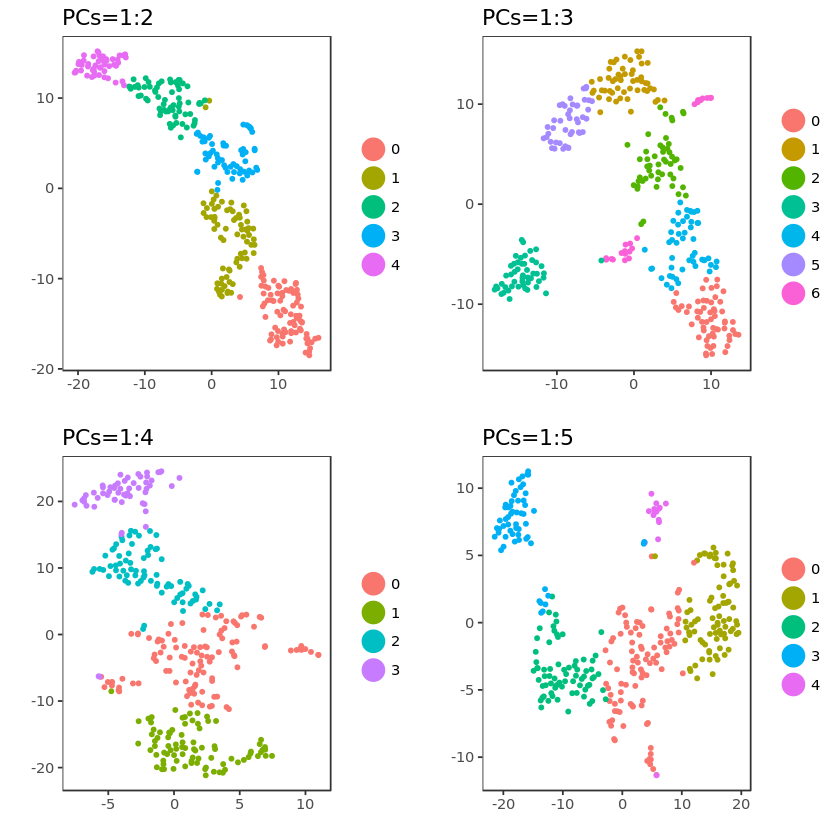

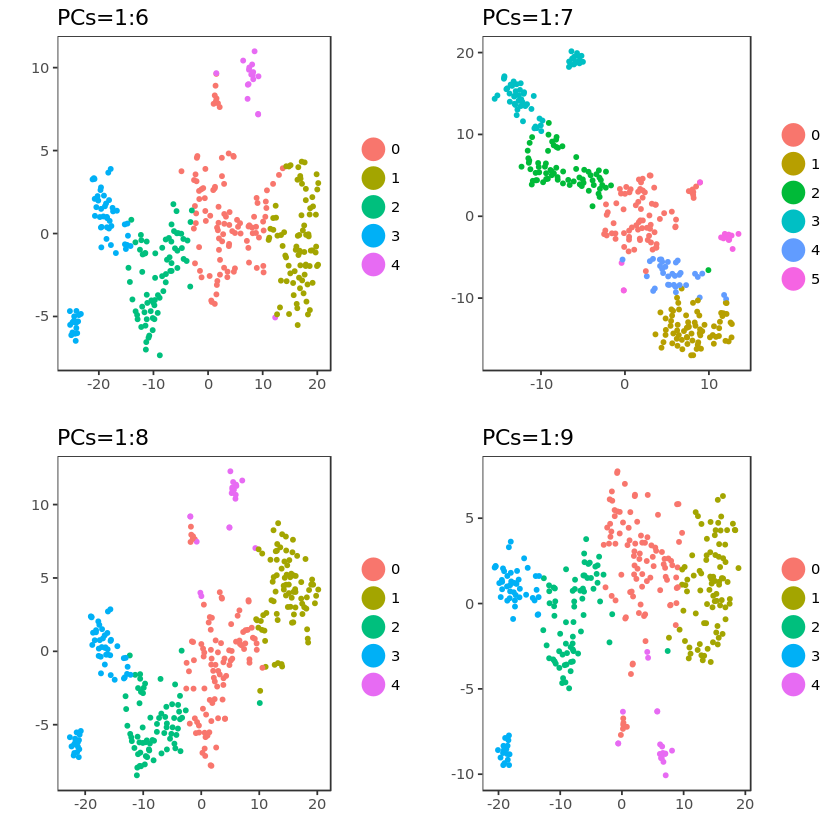

In [89]:
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- t(matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = ceiling(numPlots/cols), nrow = cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

printInteresting <- function(seu_list, range){

    multiplot(plotlist = (
        lapply(range, function(x){
            seu <- seu_list[[x]]
            return(TSNEPlot(
                object = seu, 
                do.return = T,
                label.size = 0.1
            ) + ggtitle(paste("PCs=1:",x, sep="")) + xlab("") + ylab(""))
        })
    ), cols=2
    )
}

printInteresting(tsnes_dim, 2:5)
printInteresting(tsnes_dim, 6:9)
#printInteresting(tsnes_dim, c(10,NULL))

In [92]:
marker_list <- list()

for (lim in limrange){
    marker_list[[lim]] <- FindAllMarkers(
        object = tsnes_dim[[lim]], 
        only.pos = TRUE, 
        min.pct = 0.25, 
        thresh.use = 0.25
    )
}


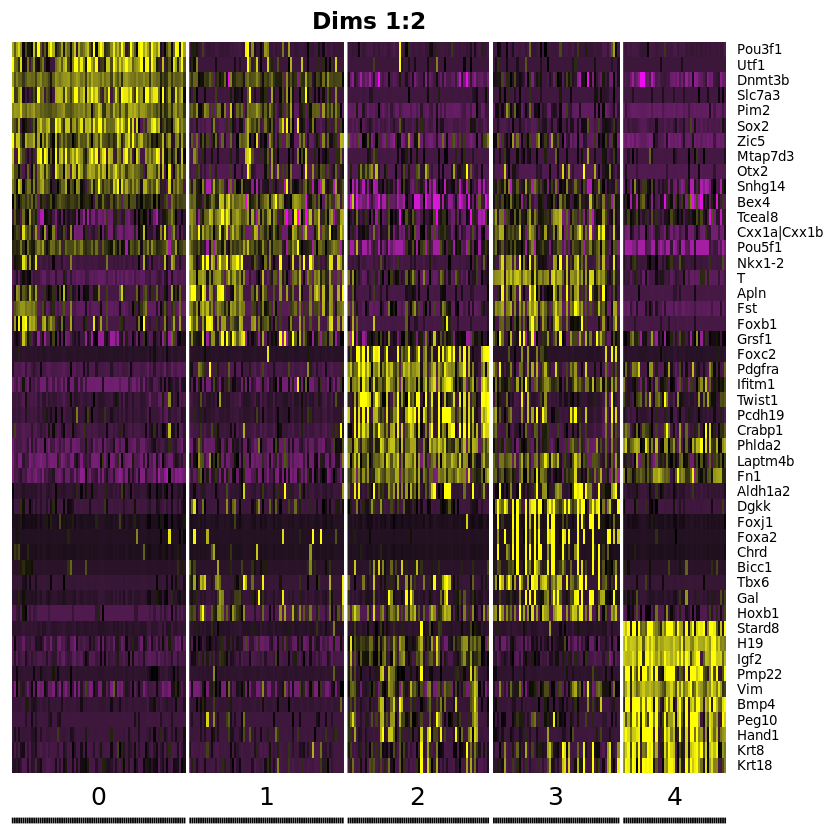

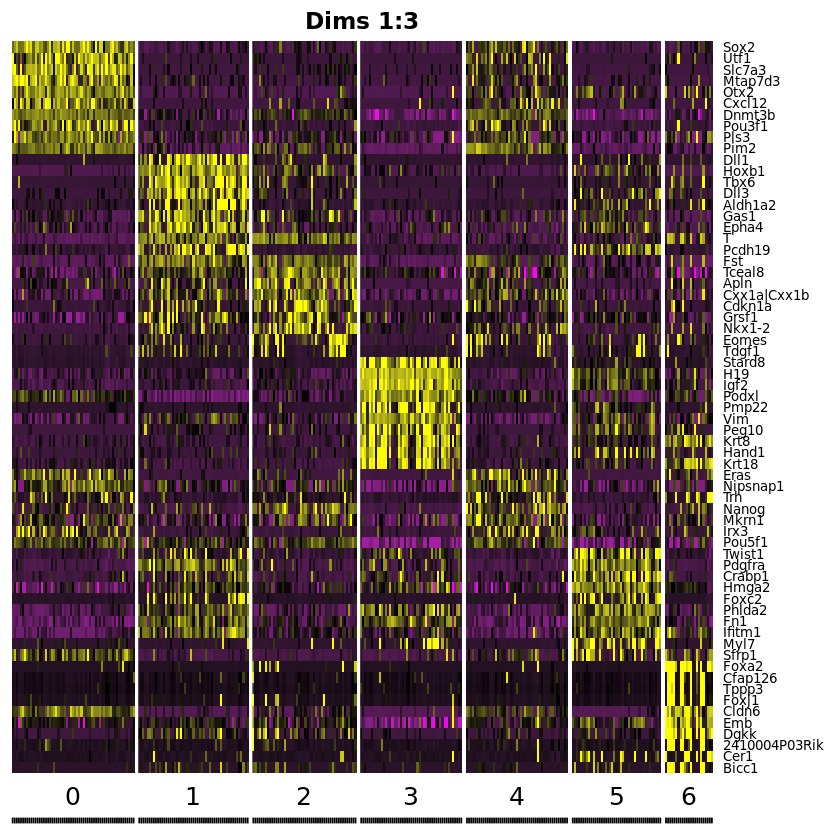

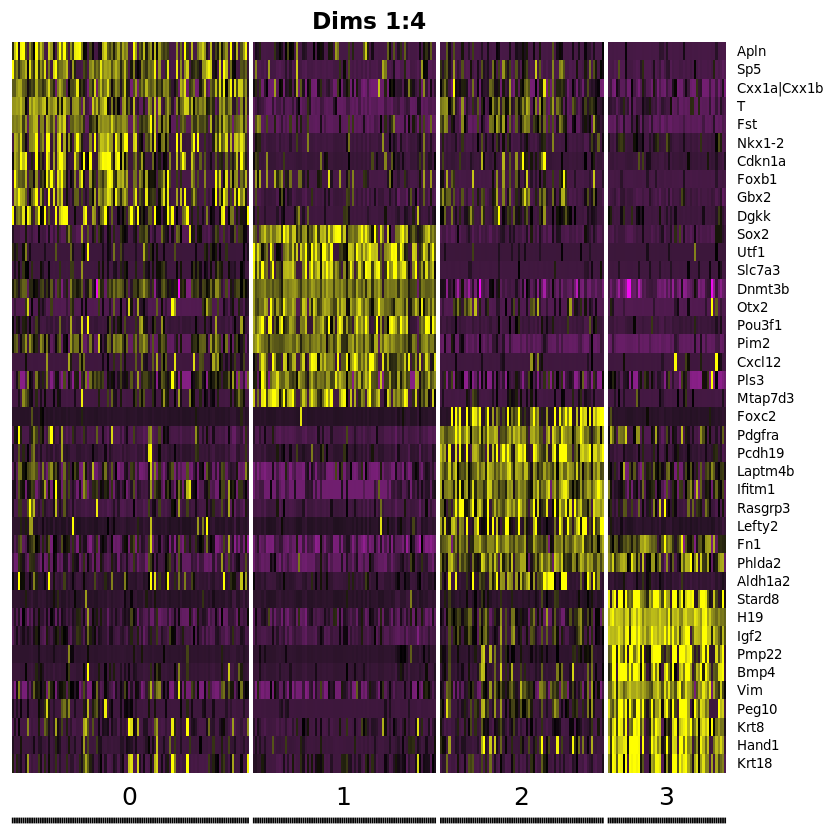

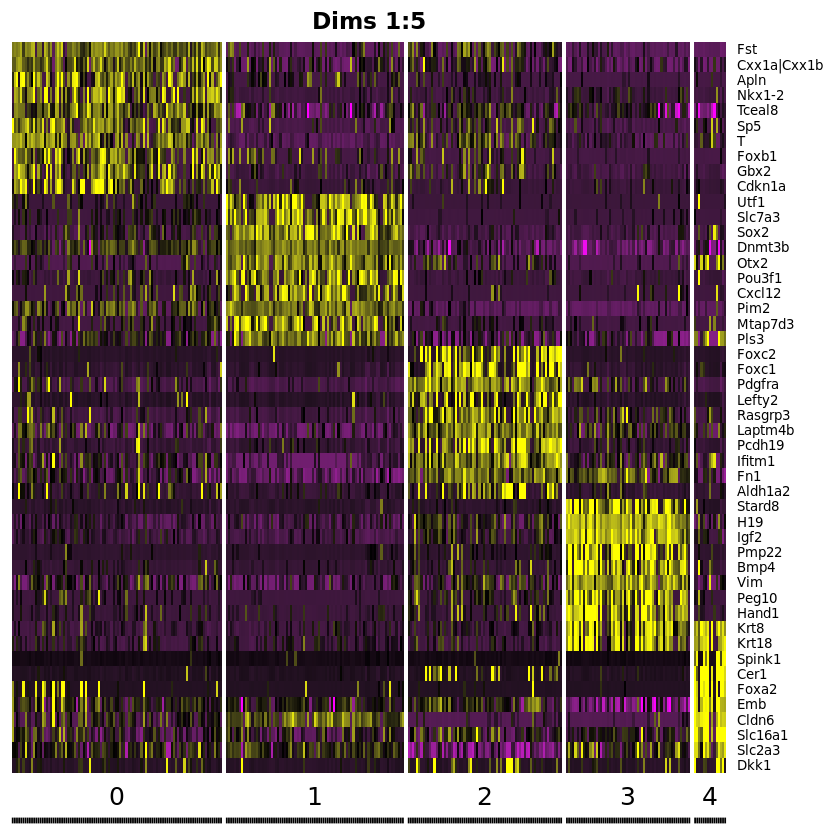

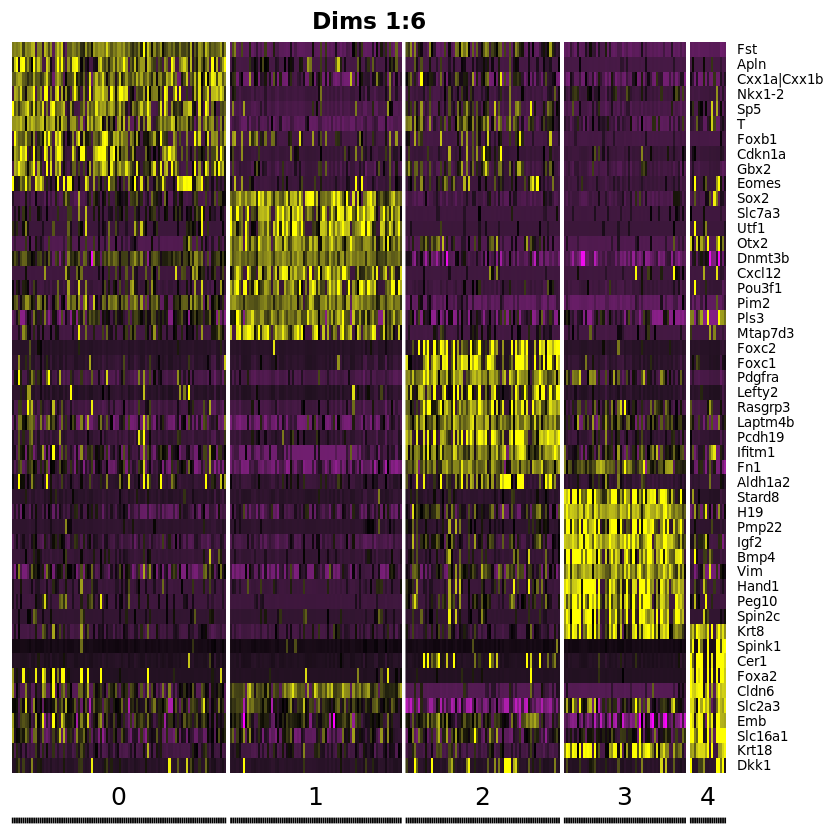

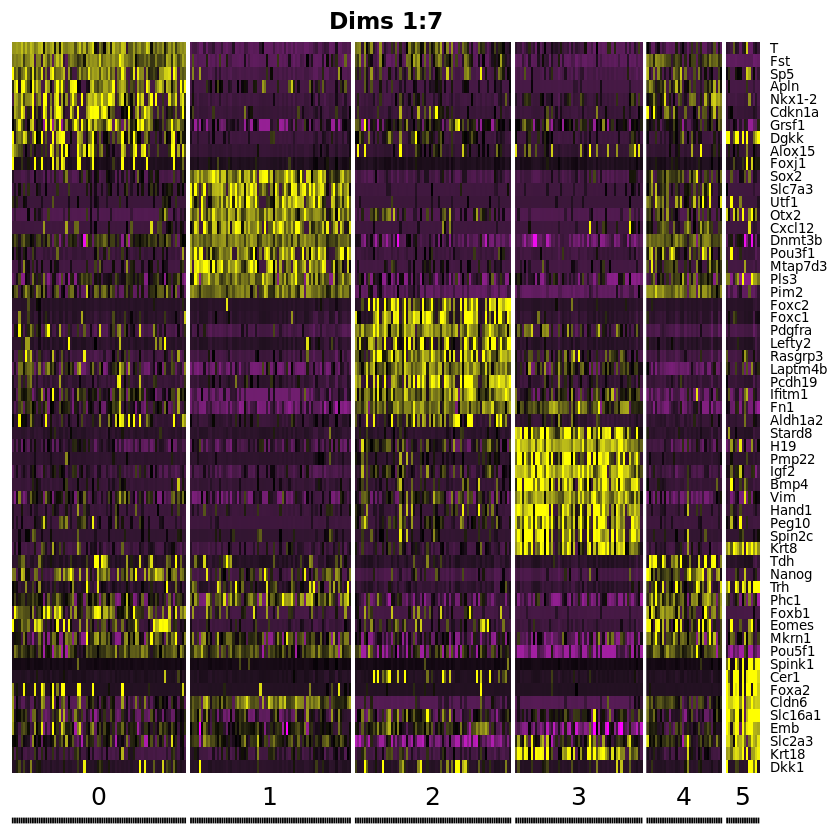

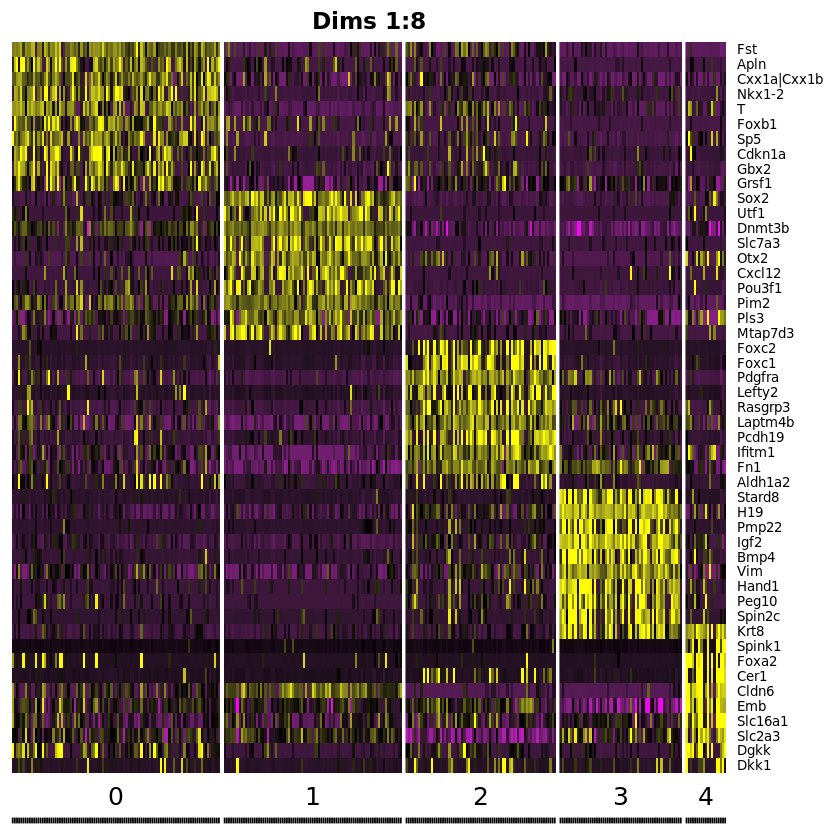

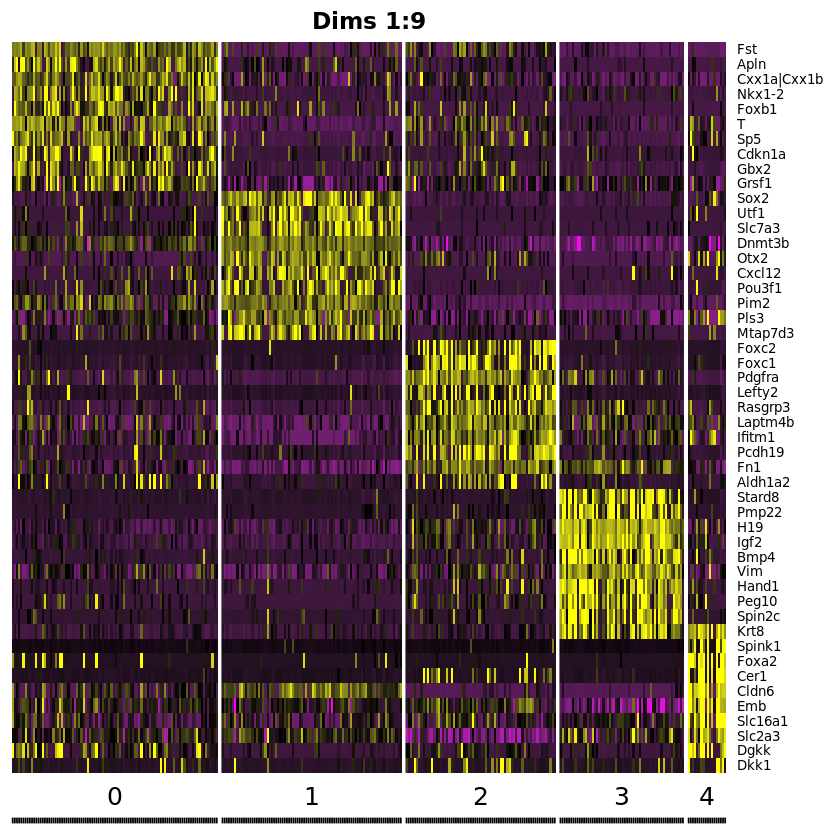

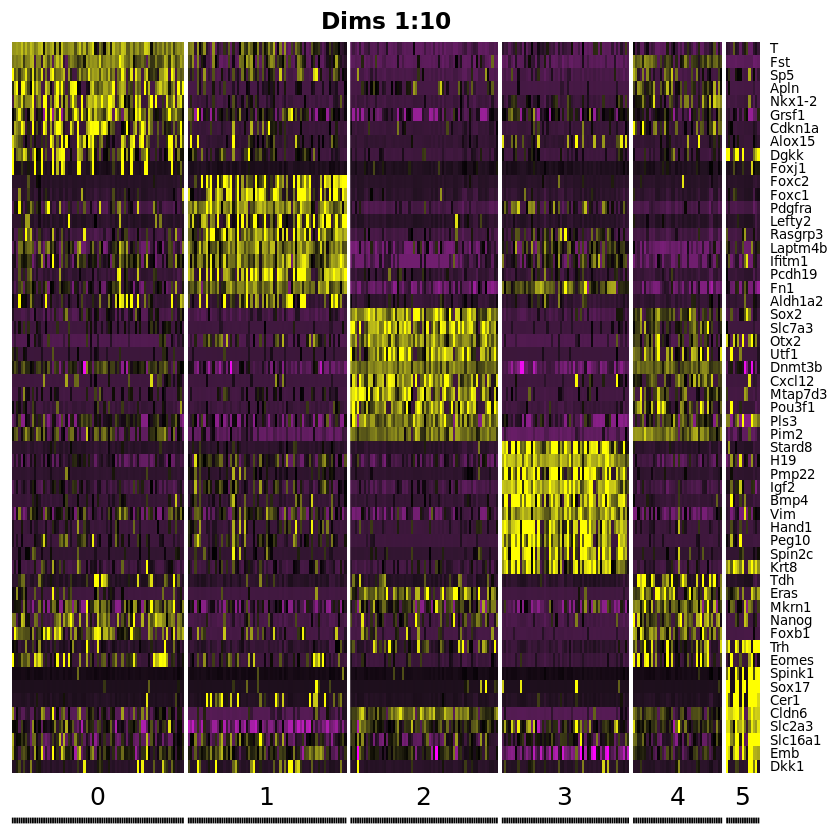

In [109]:
for (lim in limrange){
    markers <- marker_list[[lim]]
    top10 <- markers %>% group_by(cluster) %>% top_n(10, avg_logFC)
    
    print(DoHeatmap(
        object = tsnes_dim[[lim]], 
        genes.use = top10$gene,
        remove.key = TRUE,
        title = paste("Dims 1:", lim, sep=""),
        cex.col = 0,
        cex.row = 8
    ))
}


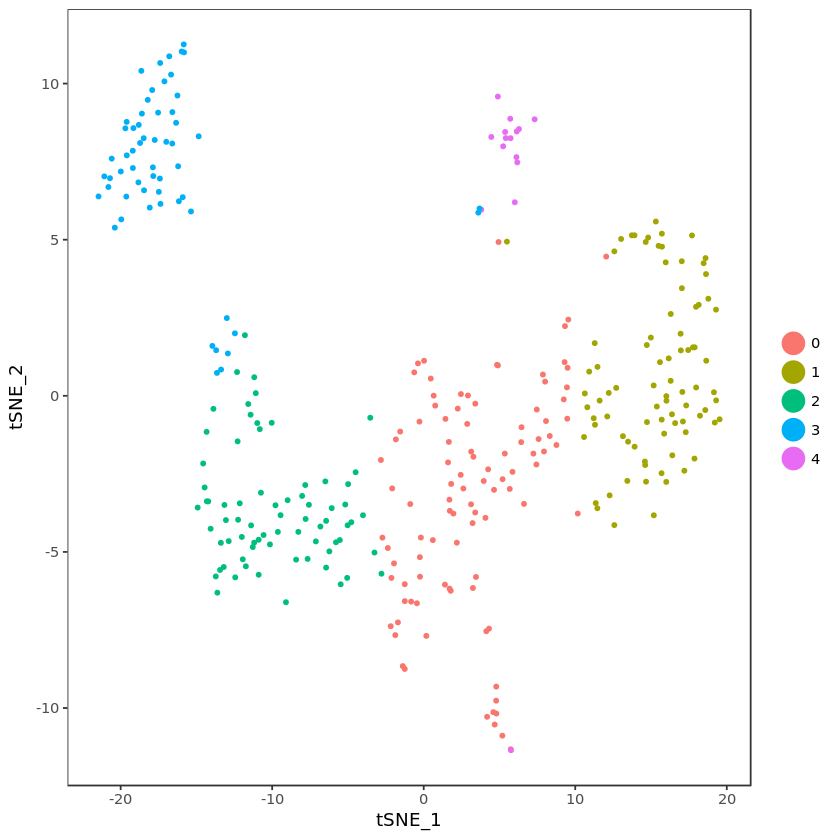

Cluster 0

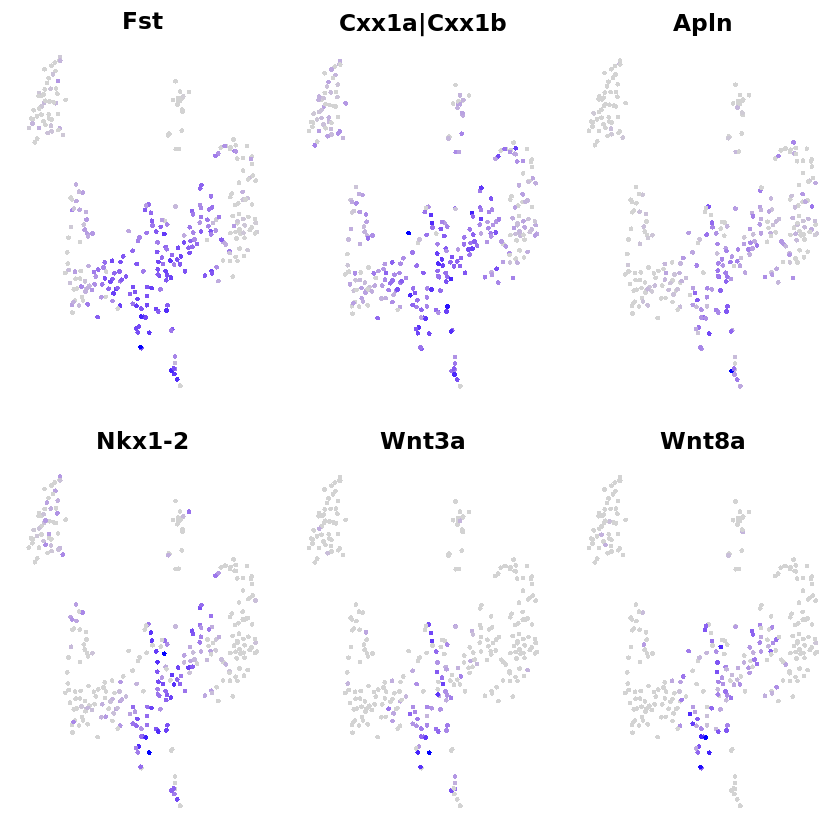

Cluster 1

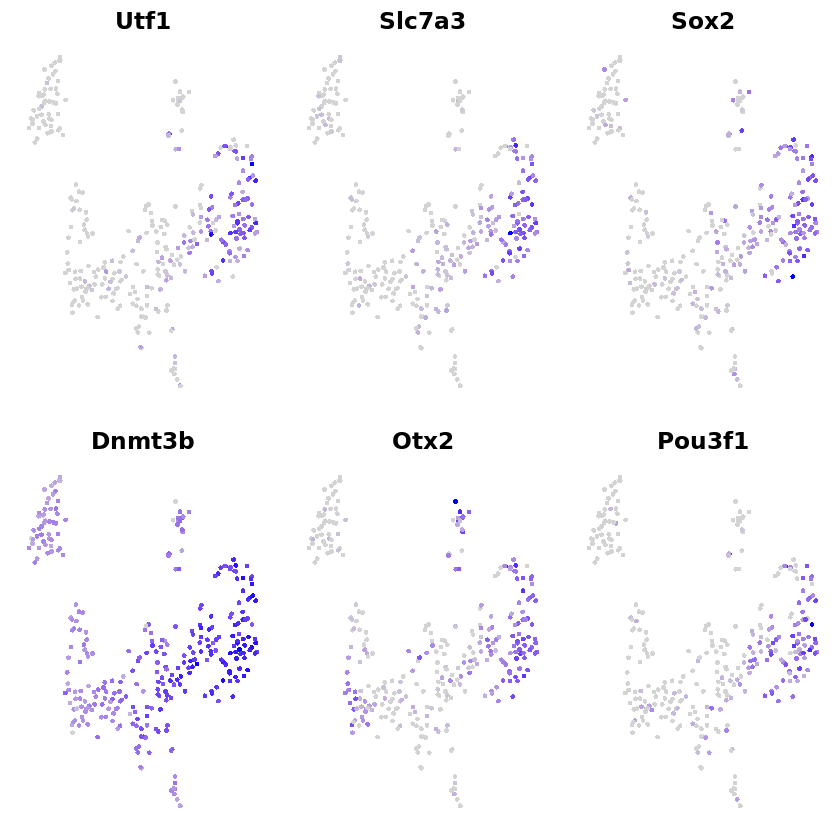

Cluster 2

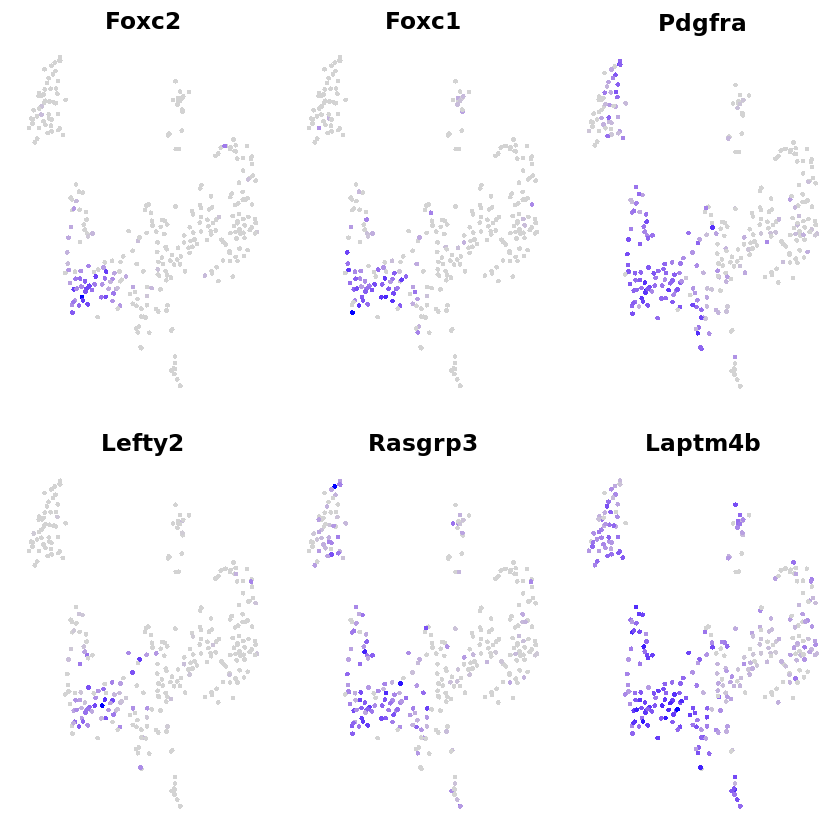

Cluster 3

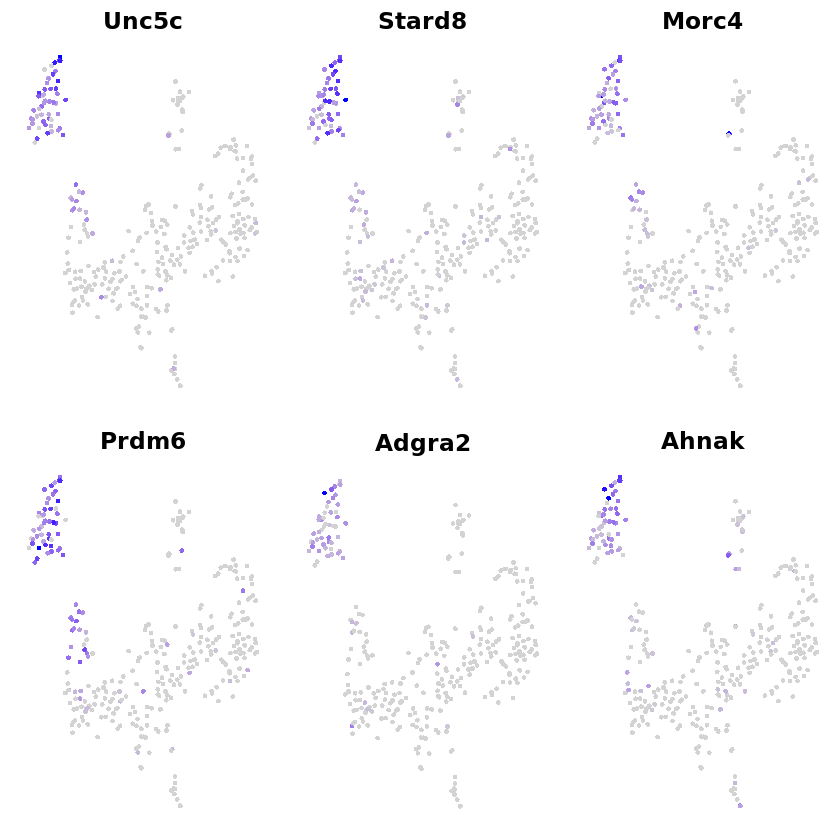

In [200]:
# Looks like dim1:3 is not that distinct
# - Dims 1:5 looks much clearer in clustering
# 
# Let us explore the four main clusters in dim 5
dimm = 5

TSNEPlot(object = tsnes_dim[[dimm]])

for (r in 0:3){
    tmp <- (head(marker_list[[dimm]][marker_list[[dimm]]$cluster == r,]$gene))          
       
    FeaturePlot(
        tsnes_dim[[dimm]], 
        tmp, 
        cols.use = c("lightgrey", "blue"),
        no.axes = T,
        nCol = 3,
    )
    cat("Cluster", r)
}